# Projet de Simulation et Monte-Carlo

## Sélection de variables

**Introduction** : dans ce NoteBook, nous vous présentons trois méthodes de sélection de variables dans une régression linéaires, toutes basées sur des méthodes inspirées du cours de Simulation et Monte-Carlo. Notre objectif d'optimisation repose sur la minimisation des critères d'information propres à une régression linéaire, l'AIC et le BIC.  Chacune de nos approches aborde le problème différemment, et nous ne prétendons pas proposer des méthodes parfaites ou infaillibles. De l'incertitude demeure autour de chaque approche, même si nous avons eu du mal à la quantifier.  

### Première partie : méthode de l'entropie croisée

L'objectif de cette méthode est de sélectionner, parmi nos p régresseurs, l'ensemble de variables qui minimise l'AIC ou le BIC (choix à effectuer). Le critère de sélection est que le paramètre $\theta$ de la distribution de Bernoulli relatif à ce régresseur soit *in fine* proche de 1.  
L'idée fondamentale repose sur notre représentation initiale des p régresseurs en tant que réalisations de lois de Bernoulli de paramètre $\theta_p$ : lorsque la réalisation vaut 1, alors on prend en compte cette variable dans la régression. Cette représentation est relativement simple à comprendre car elle se base sur une des lois les plus facilement simulables, en plus d'être naturelle (en tant que variable binaire). La taille de notre matrice est donc $n\times p$, ou $n$ correspond à la taille de notre jeu de données, et $p$ correspond au nombre de variables utilisées pour notre régression (notre base communément appelée $X$).

$$\left(\begin{array}{ccccc}
\mathcal{B}(\theta_1)&\mathcal{B}(\theta_2)&\mathcal{B}(\theta_3)&\cdots&\mathcal{B}(\theta_p)\\
\mathcal{B}(\theta_1)&\mathcal{B}(\theta_2)&\mathcal{B}(\theta_3)&\cdots&\mathcal{B}(\theta_p)\\
\vdots&\vdots&\vdots&\cdots&\vdots\\
\vdots&\vdots&\vdots&\cdots&\vdots\\
\mathcal{B}(\theta_1)&\mathcal{B}(\theta_2)&\mathcal{B}(\theta_3)&\cdots&\mathcal{B}(\theta_p)\\
\end{array}\right)$$

Le fonctionnement de l'algorithme est le suivant : 
- **Initialisation** : on initialise notre matrice de Bernoulli de taille $n\times p$ en attribuant à chaque cellule un paramètre de $\frac{1}{2}$. On créé un vecteur ligne de taille $p$ appelé `new_theta` qui stockera les nouveaux paramètres optimisés à chaque itérations. Les vecteurs de chaque itérations seront stockés au fur et à mesure dans la matrice `mat_new_theta`.  
- **Boucle** : 
    - on réalise $n$ régressions linéaires en choisissant, pour chacune d'entre elles, les variables pour lesquelles les réalisations de Bernoulli de la ligne attribuée valent $1$. On calcule alors l'AIC/BIC de chaque régression que l'on stocke dans une liste, qui est de fait de dimension $n$.
    - on range nos critères dans l'ordre croissant au sein d'une liste nommée `liste_critere_sorted`.  
    - enfin, pour chaque colonne, on fait la moyenne des $x$ meilleures composantes (la moyenne des $1$ présents sur chaque ligne de cette colonne), *i.e* les lignes qui font partie des lignes pour lesquelles les critères d'information sont dans la liste `liste_critere_sorted`. On constitue alors un vecteur ligne de taille $p$, que l'on considère comme un vecteur de nouveaux paramètres $(\theta_1,\cdots,\theta_p)$, qui est nommé `new_theta`. On recrée alors une matrice de Bernoulli de taille $n\times p$ donc les paramètres des colonnes correspondent à ceux du vecteur `new_theta`.
    - on réitère alors le processus jusqu'à ce qu'il y ait convergence des nouveaux vecteurs de paramètres : le critère d'arrêt correspond à `np.linalg.norm(mat_new_theta[t] - mat_new_theta[t-1])<1e-11`.
    **Remarque** : le critère d'arrêt peut varier. Il peut peut être parfois extrêmement long d'atteindre une distance aussi faible entre les deux vecteurs. On peut éventuellement le remplacer par `1e-9`, ou encore `1e-6`.
- **Résultat** : on affiche finalement le vecteur final de paramètres (de dimension $p$). On choisit les composantes dont les paramètres sont les plus proches de 1. Il arrive souvent que l'on obtienne des $1$ ou des $0$, ce qui facilite le choix final.    

**Quelques remarques** :  
- Lorsque l'on affiche le graphe des distances de chaque vecteur de paramètre (ce qui est automatisé dans chaque fonction), il arrive que l'on atteigne difficilement une convergence : on obtient une forme de *fuzzy caterpillar*. Aussi, particulièrement pour le critère AIC, le programme peut mettre énormément de temps à tourner.  
- Lorsque l'on fait varier le nombre d'AIC/BIC que l'on choisit à chaque itération (les $x$ meilleures composantes évoquées précédemment), le temps de convergence augmente avec le nombre choisit. Pour faire un test, on fera attention à choisir un nombre de l'ordre de 10-20 pour ne pas que ça prenne trop longtemps.  
- La fonction BIC converge beaucoup plus rapidement que la fonction AIC. On obtient le même vecteur de paramètres en un nombre d'itérations souvent plus faible.

In [1]:
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import numpy as np               # IMPORTATION DES MODULES NÉCESSAIRES
import statsmodels.api as sm
from scipy import *

In [2]:
# Y : la colonne à prédire
# x : les colonnes pour prédire

def selected_variables_aic(Y,x,nb_aic):
    n = x.shape[0] # on rentrera la taille de notre échantillon
    p = x.shape[1] # on rentrera le nombre de régresseurs
    # Initialisation des vecteurs
    normes = []
    vecteur_theta = 0.5*np.ones(p)
    mat_bernoulli = np.zeros((n,p))
    for i in range(p):
        mat_bernoulli[:,i] = bernoulli.rvs(vecteur_theta[i], size=n)
        # initialisation de la matrice de Bernoulli avec des 
        # paramètres 1/2
    t=0
    new_theta = np.zeros((p))
    mat_new_theta = np.ones((p))

    while True:
        liste_aic = []
        indices_var = []
        liste_bon_indice = []
        u=[]
        for i in range(n): # on parcourt les rangs de la matrice
             # indices des variables que l'on sélectionne pour l'OLS
            indices_var = [idx for idx,e in enumerate(mat_bernoulli[i]) 
                           if e == 1]
            X_reg = x.iloc[:, indices_var]
            X = sm.add_constant(X_reg)
            model = sm.OLS(Y,X)
            results = model.fit() # éxecution de la régression
            liste_aic.append(results.aic) # on ajoute les AIC de chaque regression
        liste_aic_sorted = sorted(liste_aic)
        # maintenant, on va faire une liste de nouveaux paramètres pour
        # chaque colonne, ou on va faire la moyenne des 0 et des 1
        # lorsque l'on est sur une ligne de "bon" AIC
        for i in range(n): # liste des indices des nb meilleurs AIC
            if liste_aic[i] in liste_aic_sorted[:nb_aic]:
                liste_bon_indice.append(i)
        for j in range(p): # itération sur les colonnes de la matrice
            for i in liste_bon_indice: 
                u.append(mat_bernoulli[i,j])
                new_theta[j] = np.mean(u) # on fait la moyenne des composantes dont les lignes
                # sont parmi celles réalisant les meilleurs AIC
        mat_new_theta = np.vstack((mat_new_theta,[new_theta]))
        # on rentre maintenant le critère d'arrêt
        if np.linalg.norm(mat_new_theta[t] - mat_new_theta[t-1])<1e-11:
            for i in range(1,mat_new_theta.shape[0]):
                normes.append(np.linalg.norm(mat_new_theta[i] - mat_new_theta[i-1]))
            print("Le nombre d'itérations est "+ str(t)+"\n"+"Les paramètres de Bernoulli finaux sont : "+ str(mat_new_theta[t]))
            plt.figure(figsize=(20,10))
            plt.plot(range(1,mat_new_theta.shape[0]),normes,"r")
            plt.ylabel('Normes des vecteurs de paramètres')
            plt.xlabel("Nombre d'itérations")
            plt.show()
            break
        else:
            for i in range(p):
                mat_bernoulli[:,i] = bernoulli.rvs(new_theta[i], size=n) 
                # on réinitialise la matrice avec les nouveaux 
                # paramètres de Bernoulli
        t=t+1 

In [3]:
def selected_variables_bic(Y,x,nb_bic):
    n = x.shape[0] # on rentrera la taille de notre échantillon
    p = x.shape[1] # on rentrera le nombre de régresseurs
    # Initialisation des vecteurs
    normes = []
    vecteur_theta = 0.5*np.ones(p)
    mat_bernoulli = np.zeros((n,p))
    for i in range(p):
        mat_bernoulli[:,i] = bernoulli.rvs(vecteur_theta[i], size=n)
    t=0
    new_theta = np.zeros((p))
    mat_new_theta = np.ones((p))

    while True:
        liste_bic = []
        indices_var = []
        liste_bon_indice = []
        u=[]
        for i in range(n): # on parcourt les rangs de la matrice
             # indices des variables que l'on sélectionne pour l'OLS
            indices_var = [idx for idx,e in enumerate(mat_bernoulli[i]) 
                           if e == 1]
            X_reg = x.iloc[:, indices_var]
            X = sm.add_constant(X_reg)
            model = sm.OLS(Y,X)
            results = model.fit() # éxecution de la régression
            liste_bic.append(results.bic) # on ajoute les AIC de chaque regression
        liste_bic_sorted = sorted(liste_bic)
        # maintenant, on va faire une liste de nouveaux paramètres pour
        # chaque colonne, ou on va faire la moyenne des 0 et des 1
        # lorsque l'on est sur une ligne de "bon" AIC
        for i in range(n): # liste des indices des nb meilleurs BIC
            if liste_bic[i] in liste_bic_sorted[:nb_bic]:
                liste_bon_indice.append(i)
        for j in range(p): # itération sur les colonnes de la matrice
            for i in liste_bon_indice:
                u.append(mat_bernoulli[i,j])
                new_theta[j] = np.mean(u) # on fait la moyenne des composantes dont les lignes
                # sont parmi celles réalisant les meilleurs AIC
        mat_new_theta = np.vstack((mat_new_theta,[new_theta]))
        # on rentre maintenant le critère d'arrêt
        if np.linalg.norm(mat_new_theta[t] - mat_new_theta[t-1])<1e-11:
            for i in range(1,mat_new_theta.shape[0]):
                normes.append(np.linalg.norm(mat_new_theta[i] - mat_new_theta[i-1]))
            print("Le nombre d'itérations est "+ str(t)+"\n"+"Les paramètres de Bernoulli finaux sont : "+ str(mat_new_theta[t]))
            plt.figure(figsize=(20,10))
            plt.plot(range(1,mat_new_theta.shape[0]),normes,"r")
            plt.ylabel('Normes des vecteurs de paramètres')
            plt.xlabel("Nombre d'itérations")
            plt.show()
            break
        else:
            for i in range(p):
                mat_bernoulli[:,i] = bernoulli.rvs(new_theta[i], size=n)
                # on réinitialise la matrice avec les nouveaux 
                # paramètres de Bernoulli
        t=t+1 

Création de la base de données grâce à un module Python dédié à la création de bases pour la régression linéaire :

In [4]:
import numpy as np
from sklearn import datasets
import pandas as pd
from statsmodels.api import OLS
from itertools import combinations
from time import time
import matplotlib.pyplot as plt
from math import *
from random import randint

def gen_data(n_samples = 1000, n_features = 10,n_informative = 5, noise = 1, coef = True, random_state = 2020):
    #We set the random_state to get reproductible results
    data, y, coef = datasets.make_regression(n_samples = n_samples, #The number of samples
                                             n_features = n_features, # The number of features
                                             n_informative = n_informative, # the number of features used to build the linear model used to generate the output
                                             noise = noise, #The standard deviation of the gaussian noise applied to the output
                                             coef = coef, #If True, the coefficients of the underlying linear model are returned.
                                            random_state = random_state #Determines random number generation for dataset creation.
                                            )
    X = pd.DataFrame(data)
    Y = pd.DataFrame(y)
    beta_true = pd.DataFrame(coef)
    
    return X,Y,beta_true

X, y, beta_true = gen_data()

Quelques tests :

Le nombre d'itérations est 29
Les paramètres de Bernoulli finaux sont : [1.         1.         1.         1.         0.8        0.66666667
 0.71428571 0.75       0.66666667 0.7       ]


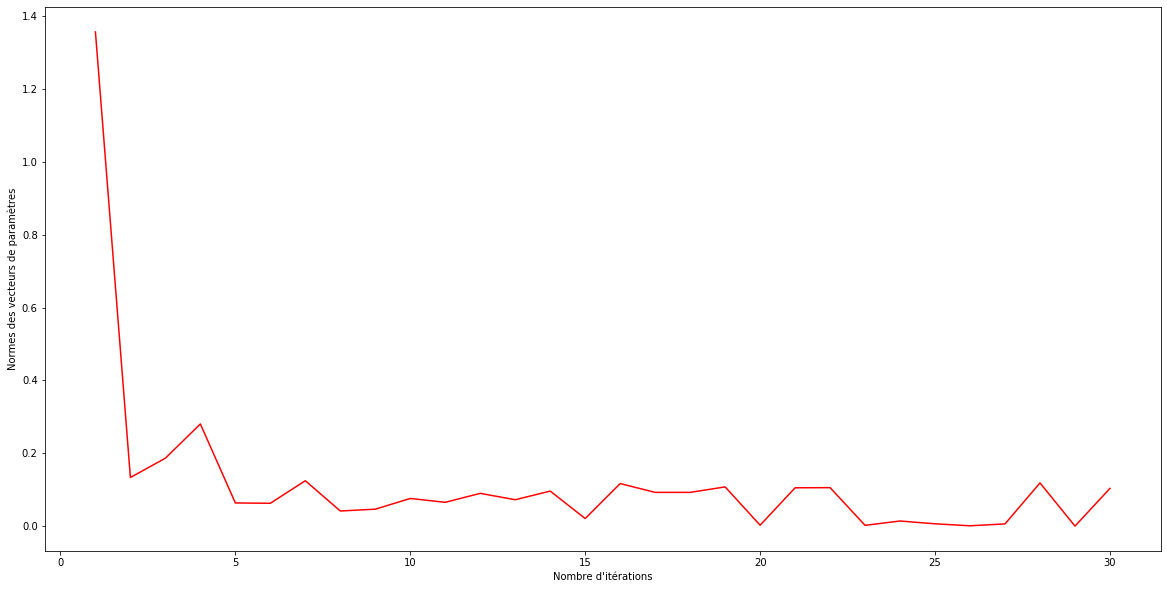

In [6]:
selected_variables_aic(y,X,10)

Le nombre d'itérations est 9
Les paramètres de Bernoulli finaux sont : [1.         1.         1.         1.         0.8        0.66666667
 0.71428571 0.75       0.66666667 0.7       ]


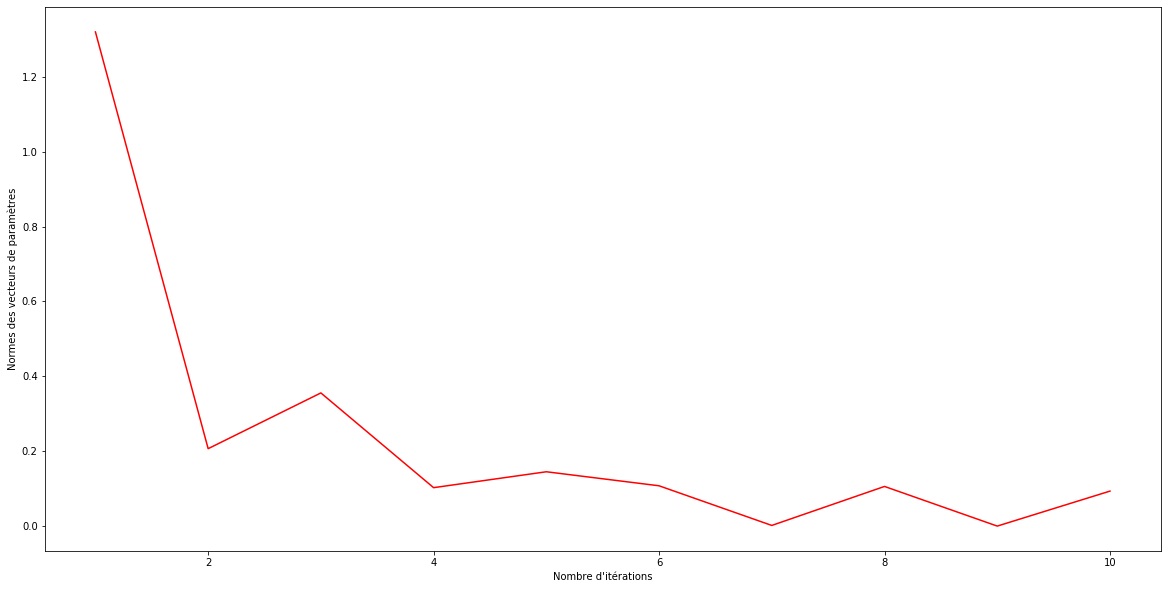

In [8]:
selected_variables_bic(y,X,10)

Le nombre d'itérations est 15
Les paramètres de Bernoulli finaux sont : [1.         1.         1.         1.         1.         0.83333333
 0.85714286 0.875      0.77777778 0.8       ]


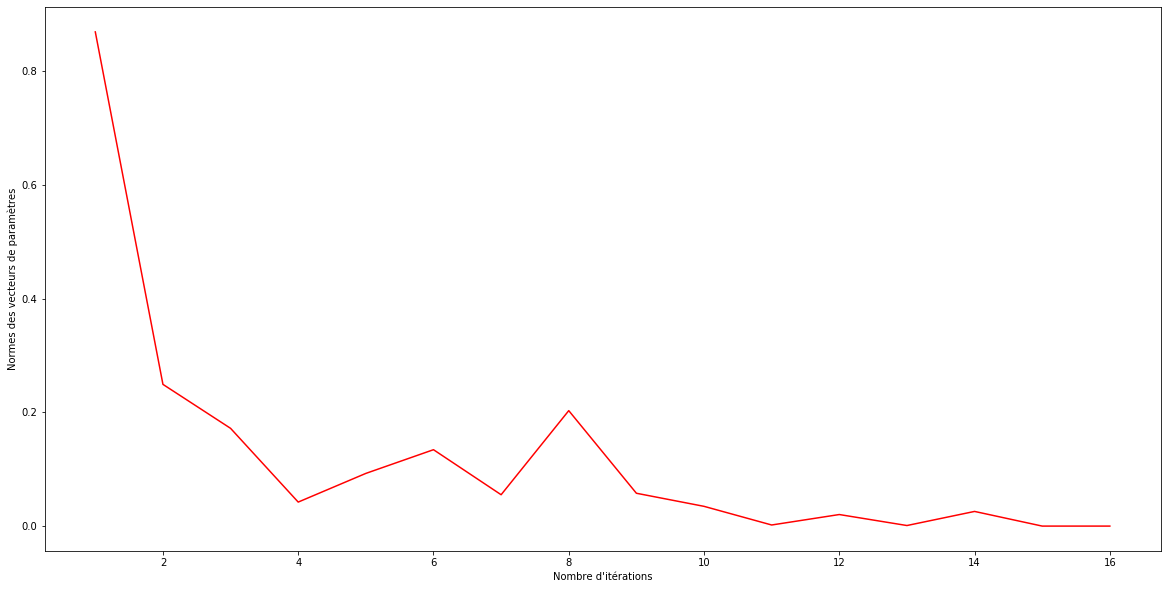

In [9]:
selected_variables_bic(y,X,20)

Le nombre d'itérations est 34
Les paramètres de Bernoulli finaux sont : [1.         1.         1.         1.         0.95333333 0.79444444
 0.82380952 0.84583333 0.77037037 0.79333333]


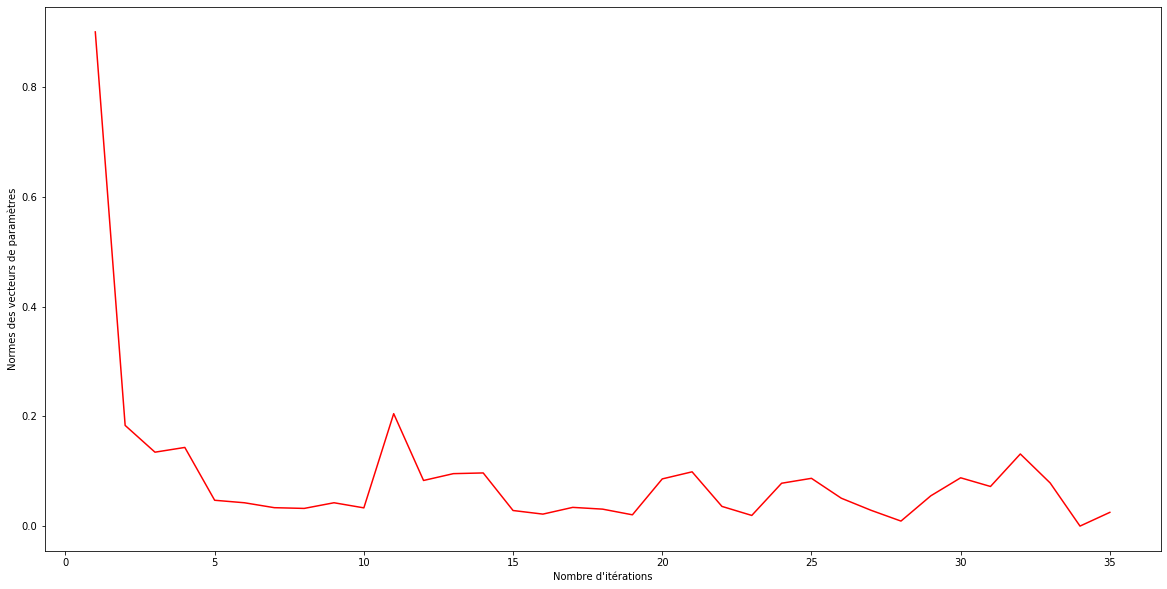

In [11]:
selected_variables_bic(y,X,30)

### Deuxième partie :

### Troisième partie :